# Libraries

In [1]:
import os
import time
import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts, MultiStepLR
import torch.nn.init as init
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from models.resnet import *

In [2]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=2)

# Configuration

In [3]:
class CFG:
    debug = False
    num_workers = 4
    batch_size = 128
    epochs = 163
    lr = 0.1
    weight_decay = 5e-4
    seed = 27
    
    #Multistep Scheduler
    milestones = [82, 123]
    gamma = 0.1
    
    #LOGS
    LOGS_DIR = './logs'

In [4]:
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(CFG.seed)

# Dataset

In [5]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [6]:
BASE_DIR = "cifar-10-batches-py"

In [7]:
data = np.empty((0, 3072))
labels = []
for i in range(1,6):
    path = os.path.join(BASE_DIR, f"data_batch_{i}")
    dict = unpickle(path)
    data = np.vstack((data, dict[b'data']))
    labels.extend(dict[b'labels'])

In [8]:
train_data, valid_data, train_labels, valid_labels = train_test_split(data, labels, test_size=0.1, random_state=CFG.seed)

In [9]:
class CifarDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = np.transpose(data.reshape(data.shape[0], 3, 32, 32), (0, 2, 3, 1))/255
        
        self.labels = np.array(labels)
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        if self.transform:
            image = self.transform(self.data[idx])
        else:
            image = torch.tensor(self.data[idx])
        label = torch.tensor(self.labels[idx])
        return image, label

In [10]:
transform_train = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Pad(4, padding_mode='reflect'),
                    transforms.RandomCrop(32),
                    transforms.RandomHorizontalFlip(),
                    
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                ]
            )

transform_test = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                ]
            )

In [11]:
train_dataset = CifarDataset(train_data, train_labels, transform_train)
valid_dataset = CifarDataset(valid_data, valid_labels, transform_test)

In [12]:
def show_img(x):
    img, label = x
    print(label)
    plt.imshow(torch.permute(img, (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(8)


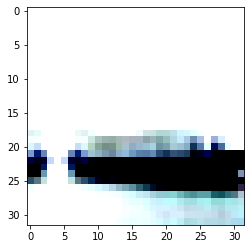

In [13]:
show_img(train_dataset[90])

In [14]:
path = os.path.join(BASE_DIR, f"test_batch")
dict = unpickle(path)
data = dict[b'data']
labels = dict[b'labels']

In [15]:
test_dataset = CifarDataset(data, labels, transform_test)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)

# Model

In [17]:
model = ResNet56()
model.to(device)

ResNet_simple(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, 

# Helper Functions

In [18]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

# Training

In [19]:
def train_fn(train_loader, model, criterion, optimizer, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    model.train()
    start = end = time.time()
    for step, (images, labels) in tqdm(enumerate(train_loader), total = len(train_loader)):
        data_time.update(time.time() - end)
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device)
        batch_size = labels.size(0)

        outputs = model(images)
        loss = criterion(outputs[3], labels)
        losses.update(loss.item(), batch_size)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        batch_time.update(time.time() - end)
        end = time.time()

    return losses.avg


In [20]:
def valid_fn(test_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    model.eval()
    start = end = time.time()
    preds = []
    valid_labels = []
    for step, (images, labels) in tqdm(enumerate(test_loader), total = len(test_loader)):
        data_time.update(time.time() - end)
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            outputs = model(images)
        loss = criterion(outputs[3], labels)
        losses.update(loss.item(), batch_size)

        preds.append(outputs[3].softmax(1).to('cpu').numpy())
        valid_labels.append(labels.to('cpu').numpy())
        
        batch_time.update(time.time() - end)
        end = time.time()

    predictions = np.concatenate(preds)
    valid_labels = np.concatenate(valid_labels)
    
    score = get_score(valid_labels, predictions.argmax(1))
    
    return losses.avg, score

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, momentum=0.9)
scheduler = MultiStepLR(optimizer, milestones=CFG.milestones, gamma=CFG.gamma, verbose=False)

In [22]:
best_score = 0
training_logs = {'train_loss':[], 'valid_loss':[], 'accuracy':[]}

for epoch in range(CFG.epochs):
    
    start_time = time.time()
    
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)
    avg_val_loss, score = valid_fn(valid_loader, model, criterion, device)
    
    scheduler.step()
    
    training_logs['train_loss'].append(avg_loss)
    training_logs['valid_loss'].append(avg_val_loss)
    training_logs['accuracy'].append(score)
    
    print(f"Epoch {epoch+1}")
    print(f"Accuracy: {score:.4f} | Train loss: {avg_loss:.4f} | Valid loss: {avg_val_loss:.4f}")
    
    if score > best_score:
        print("YES")
        best_score = score
        print(f'Save Best Score: {best_score:.4f} Model')
        torch.save(model.state_dict(), f"best_model_resnet20.pt")
        
    elapsed = time.time() - start_time

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 40.54it/s]

Epoch 1
Accuracy: 0.2947 | Train loss: 2.1208 | Valid loss: 1.8516
YES
Save Best Score: 0.2947 Model



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 40.48it/s]

Epoch 2
Accuracy: 0.4259 | Train loss: 1.7069 | Valid loss: 1.5377
YES
Save Best Score: 0.4259 Model



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 40.75it/s]

Epoch 3
Accuracy: 0.4832 | Train loss: 1.4682 | Valid loss: 1.3768
YES
Save Best Score: 0.4832 Model



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 36.23it/s]


Epoch 4
Accuracy: 0.5863 | Train loss: 1.2732 | Valid loss: 1.1548
YES
Save Best Score: 0.5863 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.59it/s]

Epoch 5
Accuracy: 0.6076 | Train loss: 1.0874 | Valid loss: 1.1078
YES
Save Best Score: 0.6076 Model



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.56it/s]

Epoch 6
Accuracy: 0.6116 | Train loss: 0.9311 | Valid loss: 1.1439
YES
Save Best Score: 0.6116 Model



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 40.32it/s]

Epoch 7
Accuracy: 0.7266 | Train loss: 0.8206 | Valid loss: 0.8090
YES
Save Best Score: 0.7266 Model



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.90it/s]


Epoch 8
Accuracy: 0.7658 | Train loss: 0.7479 | Valid loss: 0.6874
YES
Save Best Score: 0.7658 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 40.75it/s]


Epoch 9
Accuracy: 0.7480 | Train loss: 0.6953 | Valid loss: 0.7604


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.82it/s]

Epoch 10
Accuracy: 0.7812 | Train loss: 0.6621 | Valid loss: 0.6510
YES
Save Best Score: 0.7812 Model



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.98it/s]

Epoch 11
Accuracy: 0.7528 | Train loss: 0.6261 | Valid loss: 0.7111



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.91it/s]

Epoch 12
Accuracy: 0.7714 | Train loss: 0.6136 | Valid loss: 0.6734



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 41.66it/s]

Epoch 13
Accuracy: 0.7500 | Train loss: 0.5901 | Valid loss: 0.7436



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 36.48it/s]

Epoch 14
Accuracy: 0.6663 | Train loss: 0.5688 | Valid loss: 1.0450



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 38.25it/s]

Epoch 15
Accuracy: 0.7728 | Train loss: 0.5591 | Valid loss: 0.7131



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.59it/s]

Epoch 16
Accuracy: 0.7933 | Train loss: 0.5402 | Valid loss: 0.6535
YES
Save Best Score: 0.7933 Model



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 40.59it/s]

Epoch 17
Accuracy: 0.7702 | Train loss: 0.5262 | Valid loss: 0.6868



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 38.32it/s]

Epoch 18
Accuracy: 0.8119 | Train loss: 0.5286 | Valid loss: 0.5674
YES
Save Best Score: 0.8119 Model



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.84it/s]

Epoch 19
Accuracy: 0.7975 | Train loss: 0.5034 | Valid loss: 0.6185



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.12it/s]


Epoch 20
Accuracy: 0.7594 | Train loss: 0.5025 | Valid loss: 0.7472


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 39.28it/s]

Epoch 21
Accuracy: 0.7883 | Train loss: 0.4980 | Valid loss: 0.6331



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 39.20it/s]

Epoch 22
Accuracy: 0.7939 | Train loss: 0.4896 | Valid loss: 0.6309



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 40.20it/s]


Epoch 23
Accuracy: 0.7708 | Train loss: 0.4846 | Valid loss: 0.6705


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.95it/s]

Epoch 24
Accuracy: 0.8307 | Train loss: 0.4778 | Valid loss: 0.5194
YES
Save Best Score: 0.8307 Model



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.27it/s]

Epoch 25
Accuracy: 0.8189 | Train loss: 0.4766 | Valid loss: 0.5464



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.19it/s]

Epoch 26
Accuracy: 0.8231 | Train loss: 0.4696 | Valid loss: 0.5275



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 41.37it/s]

Epoch 27
Accuracy: 0.8223 | Train loss: 0.4720 | Valid loss: 0.5386



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.27it/s]

Epoch 28
Accuracy: 0.7658 | Train loss: 0.4711 | Valid loss: 0.7005



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.99it/s]

Epoch 29
Accuracy: 0.8329 | Train loss: 0.4619 | Valid loss: 0.4882
YES
Save Best Score: 0.8329 Model



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.30it/s]

Epoch 30
Accuracy: 0.8197 | Train loss: 0.4507 | Valid loss: 0.5497



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.82it/s]

Epoch 31
Accuracy: 0.8021 | Train loss: 0.4566 | Valid loss: 0.5856



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.00it/s]

Epoch 32
Accuracy: 0.8075 | Train loss: 0.4512 | Valid loss: 0.5797



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.34it/s]


Epoch 33
Accuracy: 0.7967 | Train loss: 0.4532 | Valid loss: 0.6064


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.83it/s]

Epoch 34
Accuracy: 0.7398 | Train loss: 0.4409 | Valid loss: 0.7940



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.19it/s]

Epoch 35
Accuracy: 0.7450 | Train loss: 0.4340 | Valid loss: 0.7879



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 39.72it/s]

Epoch 36
Accuracy: 0.8109 | Train loss: 0.4397 | Valid loss: 0.5721



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.70it/s]


Epoch 37
Accuracy: 0.8149 | Train loss: 0.4375 | Valid loss: 0.5813


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.47it/s]

Epoch 38
Accuracy: 0.7310 | Train loss: 0.4417 | Valid loss: 0.8542



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.26it/s]

Epoch 39
Accuracy: 0.8275 | Train loss: 0.4343 | Valid loss: 0.5261



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.25it/s]

Epoch 40
Accuracy: 0.8167 | Train loss: 0.4234 | Valid loss: 0.5538



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 36.87it/s]


Epoch 41
Accuracy: 0.8403 | Train loss: 0.4351 | Valid loss: 0.4919
YES
Save Best Score: 0.8403 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.95it/s]

Epoch 42
Accuracy: 0.8321 | Train loss: 0.4192 | Valid loss: 0.5081



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 36.94it/s]

Epoch 43
Accuracy: 0.8089 | Train loss: 0.4273 | Valid loss: 0.5798



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 39.68it/s]

Epoch 44
Accuracy: 0.8225 | Train loss: 0.4246 | Valid loss: 0.5497



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 37.43it/s]

Epoch 45
Accuracy: 0.8027 | Train loss: 0.4212 | Valid loss: 0.5919



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.31it/s]


Epoch 46
Accuracy: 0.8644 | Train loss: 0.4310 | Valid loss: 0.4054
YES
Save Best Score: 0.8644 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.34it/s]

Epoch 47
Accuracy: 0.8267 | Train loss: 0.4186 | Valid loss: 0.5254



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.39it/s]

Epoch 48
Accuracy: 0.8249 | Train loss: 0.4206 | Valid loss: 0.5526



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.48it/s]

Epoch 49
Accuracy: 0.8255 | Train loss: 0.4129 | Valid loss: 0.5237



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 40.74it/s]


Epoch 50
Accuracy: 0.8301 | Train loss: 0.4142 | Valid loss: 0.5112


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.52it/s]

Epoch 51
Accuracy: 0.7955 | Train loss: 0.4144 | Valid loss: 0.6076



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.35it/s]

Epoch 52
Accuracy: 0.8237 | Train loss: 0.4193 | Valid loss: 0.5369



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 38.06it/s]

Epoch 53
Accuracy: 0.8157 | Train loss: 0.4096 | Valid loss: 0.5862



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.08it/s]


Epoch 54
Accuracy: 0.8472 | Train loss: 0.4139 | Valid loss: 0.4557


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.84it/s]

Epoch 55
Accuracy: 0.8387 | Train loss: 0.4124 | Valid loss: 0.4856



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.76it/s]

Epoch 56
Accuracy: 0.8017 | Train loss: 0.4136 | Valid loss: 0.6045



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.06it/s]

Epoch 57
Accuracy: 0.8233 | Train loss: 0.4165 | Valid loss: 0.5252



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.37it/s]

Epoch 58
Accuracy: 0.8405 | Train loss: 0.4108 | Valid loss: 0.4762



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 38.95it/s]

Epoch 59
Accuracy: 0.8289 | Train loss: 0.4039 | Valid loss: 0.5063



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 40.80it/s]

Epoch 60
Accuracy: 0.8237 | Train loss: 0.4102 | Valid loss: 0.5113



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.32it/s]


Epoch 61
Accuracy: 0.8185 | Train loss: 0.4088 | Valid loss: 0.5754


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.02it/s]

Epoch 62
Accuracy: 0.8175 | Train loss: 0.4026 | Valid loss: 0.5510



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 40.65it/s]

Epoch 63
Accuracy: 0.8331 | Train loss: 0.4008 | Valid loss: 0.5043



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 40.56it/s]

Epoch 64
Accuracy: 0.7652 | Train loss: 0.4082 | Valid loss: 0.7406



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 39.40it/s]

Epoch 65
Accuracy: 0.8059 | Train loss: 0.4039 | Valid loss: 0.5763



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 40.89it/s]

Epoch 66
Accuracy: 0.8109 | Train loss: 0.4027 | Valid loss: 0.5751



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.54it/s]

Epoch 67
Accuracy: 0.8207 | Train loss: 0.4143 | Valid loss: 0.5440



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.21it/s]

Epoch 68
Accuracy: 0.7815 | Train loss: 0.4024 | Valid loss: 0.6925



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 42.31it/s]

Epoch 69
Accuracy: 0.8309 | Train loss: 0.4070 | Valid loss: 0.5005



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 36.47it/s]

Epoch 70
Accuracy: 0.8295 | Train loss: 0.4032 | Valid loss: 0.4917



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.78it/s]

Epoch 71
Accuracy: 0.7855 | Train loss: 0.4036 | Valid loss: 0.6645



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 41.79it/s]


Epoch 72
Accuracy: 0.8127 | Train loss: 0.3995 | Valid loss: 0.5693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.64it/s]

Epoch 73
Accuracy: 0.8431 | Train loss: 0.3983 | Valid loss: 0.4618



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 36.66it/s]

Epoch 74
Accuracy: 0.8345 | Train loss: 0.3963 | Valid loss: 0.5190



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.59it/s]

Epoch 75
Accuracy: 0.8065 | Train loss: 0.3972 | Valid loss: 0.5995



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.30it/s]

Epoch 76
Accuracy: 0.8287 | Train loss: 0.3990 | Valid loss: 0.4935



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.03it/s]

Epoch 77
Accuracy: 0.8279 | Train loss: 0.4024 | Valid loss: 0.5168



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 41.58it/s]

Epoch 78
Accuracy: 0.7560 | Train loss: 0.3925 | Valid loss: 0.8075



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.61it/s]

Epoch 79
Accuracy: 0.8081 | Train loss: 0.3984 | Valid loss: 0.5674



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 40.92it/s]

Epoch 80
Accuracy: 0.8211 | Train loss: 0.4017 | Valid loss: 0.5477



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.30it/s]

Epoch 81
Accuracy: 0.8255 | Train loss: 0.3975 | Valid loss: 0.5236



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.57it/s]


Epoch 82
Accuracy: 0.8347 | Train loss: 0.3989 | Valid loss: 0.4872


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 42.16it/s]


Epoch 83
Accuracy: 0.9191 | Train loss: 0.2354 | Valid loss: 0.2309
YES
Save Best Score: 0.9191 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.21it/s]

Epoch 84
Accuracy: 0.9257 | Train loss: 0.1879 | Valid loss: 0.2194
YES
Save Best Score: 0.9257 Model



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.73it/s]

Epoch 85
Accuracy: 0.9249 | Train loss: 0.1706 | Valid loss: 0.2140



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.35it/s]

Epoch 86
Accuracy: 0.9267 | Train loss: 0.1544 | Valid loss: 0.2128
YES
Save Best Score: 0.9267 Model



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 35.19it/s]


Epoch 87
Accuracy: 0.9301 | Train loss: 0.1434 | Valid loss: 0.2039
YES
Save Best Score: 0.9301 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.87it/s]

Epoch 88
Accuracy: 0.9285 | Train loss: 0.1376 | Valid loss: 0.2065



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.73it/s]

Epoch 89
Accuracy: 0.9279 | Train loss: 0.1275 | Valid loss: 0.2215



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.62it/s]

Epoch 90
Accuracy: 0.9347 | Train loss: 0.1212 | Valid loss: 0.2131
YES
Save Best Score: 0.9347 Model



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.59it/s]

Epoch 91
Accuracy: 0.9325 | Train loss: 0.1156 | Valid loss: 0.2116



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.56it/s]

Epoch 92
Accuracy: 0.9293 | Train loss: 0.1115 | Valid loss: 0.2139



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.31it/s]

Epoch 93
Accuracy: 0.9255 | Train loss: 0.1026 | Valid loss: 0.2254



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 41.63it/s]

Epoch 94
Accuracy: 0.9305 | Train loss: 0.1030 | Valid loss: 0.2184



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.63it/s]

Epoch 95
Accuracy: 0.9249 | Train loss: 0.0987 | Valid loss: 0.2356



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.57it/s]

Epoch 96
Accuracy: 0.9291 | Train loss: 0.0936 | Valid loss: 0.2287



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 39.83it/s]

Epoch 100
Accuracy: 0.9255 | Train loss: 0.0895 | Valid loss: 0.2465



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.50it/s]

Epoch 101
Accuracy: 0.9263 | Train loss: 0.0866 | Valid loss: 0.2453



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.57it/s]

Epoch 102
Accuracy: 0.9211 | Train loss: 0.0816 | Valid loss: 0.2464



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.98it/s]

Epoch 103
Accuracy: 0.9269 | Train loss: 0.0849 | Valid loss: 0.2529



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.72it/s]

Epoch 104
Accuracy: 0.9177 | Train loss: 0.0809 | Valid loss: 0.2726



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.66it/s]

Epoch 105
Accuracy: 0.9235 | Train loss: 0.0825 | Valid loss: 0.2576



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.87it/s]

Epoch 106
Accuracy: 0.9241 | Train loss: 0.0816 | Valid loss: 0.2579



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 34.98it/s]


Epoch 107
Accuracy: 0.9263 | Train loss: 0.0841 | Valid loss: 0.2520


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.82it/s]

Epoch 108
Accuracy: 0.9217 | Train loss: 0.0867 | Valid loss: 0.2578



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 17.47it/s]

Epoch 109
Accuracy: 0.9185 | Train loss: 0.0805 | Valid loss: 0.2722



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 28.87it/s]

Epoch 110
Accuracy: 0.9191 | Train loss: 0.0825 | Valid loss: 0.2749



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 29.81it/s]

Epoch 111
Accuracy: 0.9123 | Train loss: 0.0861 | Valid loss: 0.3022



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.28it/s]

Epoch 112
Accuracy: 0.9215 | Train loss: 0.0811 | Valid loss: 0.2610



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.02it/s]

Epoch 113
Accuracy: 0.9181 | Train loss: 0.0820 | Valid loss: 0.2781



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.56it/s]

Epoch 114
Accuracy: 0.9193 | Train loss: 0.0824 | Valid loss: 0.2849



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 28.83it/s]

Epoch 115
Accuracy: 0.9209 | Train loss: 0.0816 | Valid loss: 0.2581



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.50it/s]

Epoch 116
Accuracy: 0.9185 | Train loss: 0.0848 | Valid loss: 0.2680



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 24.66it/s]

Epoch 117
Accuracy: 0.9173 | Train loss: 0.0837 | Valid loss: 0.2680



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 24.30it/s]

Epoch 118
Accuracy: 0.9205 | Train loss: 0.0841 | Valid loss: 0.2661



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 24.21it/s]

Epoch 119
Accuracy: 0.9207 | Train loss: 0.0871 | Valid loss: 0.2631



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 16.84it/s]

Epoch 120
Accuracy: 0.9239 | Train loss: 0.0833 | Valid loss: 0.2531



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 19.75it/s]

Epoch 121
Accuracy: 0.9157 | Train loss: 0.0847 | Valid loss: 0.2802



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.15it/s]

Epoch 122
Accuracy: 0.9127 | Train loss: 0.0853 | Valid loss: 0.3062



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.60it/s]


Epoch 123
Accuracy: 0.9101 | Train loss: 0.0836 | Valid loss: 0.2909


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 26.55it/s]

Epoch 124
Accuracy: 0.9331 | Train loss: 0.0493 | Valid loss: 0.2207



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 25.54it/s]

Epoch 125
Accuracy: 0.9339 | Train loss: 0.0340 | Valid loss: 0.2202



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.03it/s]

Epoch 126
Accuracy: 0.9361 | Train loss: 0.0286 | Valid loss: 0.2113
YES
Save Best Score: 0.9361 Model



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.69it/s]

Epoch 127
Accuracy: 0.9365 | Train loss: 0.0273 | Valid loss: 0.2118
YES
Save Best Score: 0.9365 Model



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.13it/s]

Epoch 128
Accuracy: 0.9353 | Train loss: 0.0229 | Valid loss: 0.2196



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 24.07it/s]

Epoch 129
Accuracy: 0.9347 | Train loss: 0.0229 | Valid loss: 0.2178



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 24.39it/s]


Epoch 130
Accuracy: 0.9377 | Train loss: 0.0207 | Valid loss: 0.2133
YES
Save Best Score: 0.9377 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 22.86it/s]

Epoch 131
Accuracy: 0.9349 | Train loss: 0.0202 | Valid loss: 0.2176



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 28.18it/s]

Epoch 132
Accuracy: 0.9355 | Train loss: 0.0180 | Valid loss: 0.2229



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 24.15it/s]

Epoch 133
Accuracy: 0.9393 | Train loss: 0.0177 | Valid loss: 0.2192
YES
Save Best Score: 0.9393 Model



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 28.06it/s]


Epoch 134
Accuracy: 0.9399 | Train loss: 0.0186 | Valid loss: 0.2161
YES
Save Best Score: 0.9399 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 24.20it/s]

Epoch 135
Accuracy: 0.9397 | Train loss: 0.0158 | Valid loss: 0.2158



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 26.75it/s]

Epoch 136
Accuracy: 0.9383 | Train loss: 0.0156 | Valid loss: 0.2151



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 24.56it/s]

Epoch 137
Accuracy: 0.9385 | Train loss: 0.0154 | Valid loss: 0.2154



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 25.41it/s]

Epoch 138
Accuracy: 0.9377 | Train loss: 0.0146 | Valid loss: 0.2236



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 16.62it/s]

Epoch 139
Accuracy: 0.9399 | Train loss: 0.0140 | Valid loss: 0.2166



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.40it/s]


Epoch 140
Accuracy: 0.9421 | Train loss: 0.0139 | Valid loss: 0.2182
YES
Save Best Score: 0.9421 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 26.57it/s]

Epoch 141
Accuracy: 0.9381 | Train loss: 0.0143 | Valid loss: 0.2198



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.00it/s]

Epoch 142
Accuracy: 0.9403 | Train loss: 0.0131 | Valid loss: 0.2192



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.30it/s]

Epoch 143
Accuracy: 0.9403 | Train loss: 0.0127 | Valid loss: 0.2220



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 26.72it/s]

Epoch 144
Accuracy: 0.9373 | Train loss: 0.0116 | Valid loss: 0.2286



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.57it/s]

Epoch 145
Accuracy: 0.9377 | Train loss: 0.0117 | Valid loss: 0.2224



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 25.86it/s]

Epoch 146
Accuracy: 0.9403 | Train loss: 0.0117 | Valid loss: 0.2210



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 25.61it/s]

Epoch 147
Accuracy: 0.9393 | Train loss: 0.0119 | Valid loss: 0.2225



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 26.19it/s]

Epoch 148
Accuracy: 0.9401 | Train loss: 0.0110 | Valid loss: 0.2253



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 26.77it/s]

Epoch 149
Accuracy: 0.9371 | Train loss: 0.0110 | Valid loss: 0.2262



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.10it/s]

Epoch 150
Accuracy: 0.9373 | Train loss: 0.0111 | Valid loss: 0.2291



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 25.97it/s]

Epoch 151
Accuracy: 0.9379 | Train loss: 0.0105 | Valid loss: 0.2260



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 24.57it/s]

Epoch 152
Accuracy: 0.9369 | Train loss: 0.0102 | Valid loss: 0.2251



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 24.23it/s]

Epoch 153
Accuracy: 0.9383 | Train loss: 0.0096 | Valid loss: 0.2246



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 25.63it/s]

Epoch 154
Accuracy: 0.9397 | Train loss: 0.0098 | Valid loss: 0.2281



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 24.99it/s]

Epoch 155
Accuracy: 0.9365 | Train loss: 0.0097 | Valid loss: 0.2260



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.31it/s]

Epoch 156
Accuracy: 0.9387 | Train loss: 0.0098 | Valid loss: 0.2264



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.63it/s]

Epoch 157
Accuracy: 0.9381 | Train loss: 0.0089 | Valid loss: 0.2283



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 24.96it/s]

Epoch 158
Accuracy: 0.9411 | Train loss: 0.0089 | Valid loss: 0.2217



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.26it/s]

Epoch 159
Accuracy: 0.9387 | Train loss: 0.0098 | Valid loss: 0.2254



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 23.55it/s]

Epoch 160
Accuracy: 0.9391 | Train loss: 0.0092 | Valid loss: 0.2300



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 27.35it/s]

Epoch 161
Accuracy: 0.9391 | Train loss: 0.0089 | Valid loss: 0.2337



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.59it/s]

Epoch 162
Accuracy: 0.9389 | Train loss: 0.0093 | Valid loss: 0.2312



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 21.18it/s]

Epoch 163
Accuracy: 0.9379 | Train loss: 0.0087 | Valid loss: 0.2334


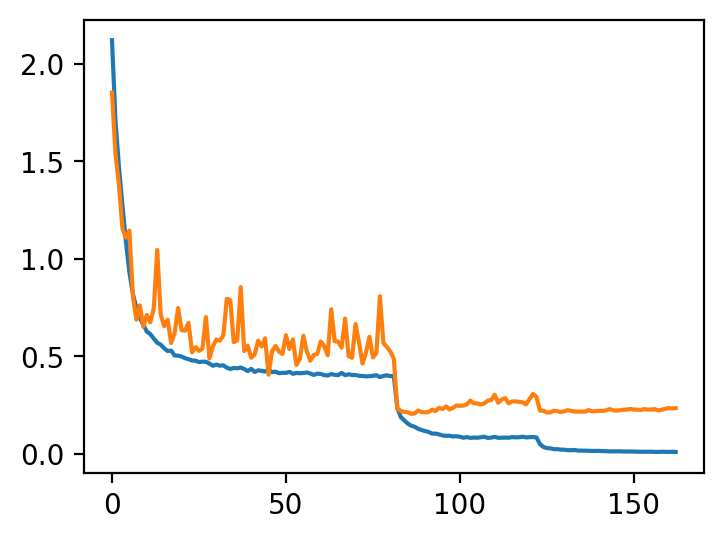

In [23]:
plt.figure(figsize=(4, 3), dpi=200)
plt.plot(training_logs['train_loss'])
plt.plot(training_logs['valid_loss'])

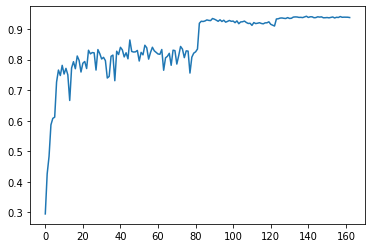

In [24]:
plt.plot(training_logs['accuracy'])

In [25]:
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

In [26]:
torch.save(model.state_dict(), f"last_model_resnet20.pt")

In [34]:
model.load_state_dict(torch.load("./last_model_resnet20.pt"))

<All keys matched successfully>

In [35]:
preds = []
valid_labels = []

model.eval()
for step, (images, labels) in tqdm(enumerate(test_loader), total = len(test_loader)):

    images = images.to(device, dtype=torch.float)
    labels = labels.to(device)
    batch_size = labels.size(0)

    with torch.no_grad():
        outputs = model(images)
        
    preds.append(outputs[3].softmax(1).to('cpu').numpy())
    valid_labels.append(labels.to('cpu').numpy())

predictions = np.concatenate(preds)
valid_labels = np.concatenate(valid_labels)

score = get_score(valid_labels, predictions.argmax(1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 26.89it/s]


In [33]:
score

0.933

In [36]:
score # best

0.9351